# Analysing output from sqlite pipeline

In [1]:
import pandas as pd
import sqlite3

## 1. Load in data from local SQL db

In [14]:
con = sqlite3.connect("dwh/db")

df = pd.read_sql_query("select * from fact_invoices", con)

df.info()

con.close()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317 entries, 0 to 316
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     317 non-null    int64  
 1   id        317 non-null    object 
 2   currency  317 non-null    object 
 3   customer  317 non-null    object 
 4   total     317 non-null    float64
 5   date      317 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 15.0+ KB


## 2. Calculate average order value
Since we already converted total to the proper values in our pipeline no further transformation is needed.

In [44]:
df["total"].mean()

452.3659305993691

## 3. Joining multiple tables to calculate revenue per market

### 3.1 Using SQL to join

In [16]:
con = sqlite3.connect("dwh/db")

df = pd.read_sql_query("""
select
    i.id,
    i.currency,
    i.customer,
    i.total,
    i.date,
    c.id as id_customer,
    c.name,
    c.email,
    c.country
from fact_invoices as i
left join dim_customer as c
    on i.customer = c.id
""", con)

df.info()

con.close()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317 entries, 0 to 316
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           317 non-null    object 
 1   currency     317 non-null    object 
 2   customer     317 non-null    object 
 3   total        317 non-null    float64
 4   date         317 non-null    object 
 5   id_customer  317 non-null    object 
 6   name         317 non-null    object 
 7   email        317 non-null    object 
 8   country      317 non-null    object 
dtypes: float64(1), object(8)
memory usage: 22.4+ KB


### 3.2 Using pandas to join

In [23]:
con = sqlite3.connect("dwh/db")

in_df = pd.read_sql_query("select * from fact_invoices", con)
cu_df = pd.read_sql_query("select * from dim_customer", con)

df = in_df.merge(cu_df, left_on="customer", right_on="id", suffixes=[None, "_customer"])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317 entries, 0 to 316
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           317 non-null    object 
 1   currency     317 non-null    object 
 2   customer     317 non-null    object 
 3   total        317 non-null    float64
 4   date         317 non-null    object 
 5   id_customer  317 non-null    object 
 6   name         317 non-null    object 
 7   email        317 non-null    object 
 8   country      317 non-null    object 
dtypes: float64(1), object(8)
memory usage: 22.4+ KB


### 3.3 Calculating revenue per country

<Axes: xlabel='country'>

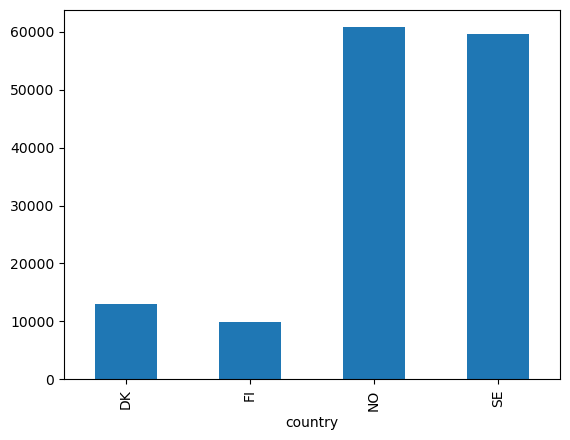

In [26]:
total_by_country = df.groupby("country")["total"].sum()

total_by_country.plot.bar()